In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy.spatial.distance import pdist
import pickle

import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
from tqdm.notebook import tqdm

from Utils import myUtils as mypy
from Analysis import processQuantStudio as pQS
from Analysis import PYMCutils as pmu


%config InlineBackend.figure_format ='retina'
%config Completer.use_jedi = False
%load_ext Utils.skip_kernel_ext
%load_ext autoreload
%aimport Utils
%aimport Analysis
#%aimport pcr
#pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
code_pth, base_pth, data_pth, rslt_pth, fig_pth = mypy.setupPath()
plt.style.use(str(code_pth / 'Utils' / 'futura_presentation.mplstyle'))

def savemyfig(fig,name,path=fig_pth):
    mypy.savemyfig(fig,'JG047 '+name,path)

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Load in parameter estimates

In [4]:
genes = ['GBP6','TMCC1','ARG1']
gene_coords = {'GBP6':0,'TMCC1':1,'ARG1':2}
palette = sns.cubehelix_palette(light=0.95)

rxn_ests = pd.read_pickle(rslt_pth / 'JG047 Reaction Parameters.pkl')
param_stats = rxn_ests.groupby(['Gene','Tar','BP_z','GC_z','BP','GC','Parameter'])['mean'].describe().reset_index()

In [5]:
rxn_ests

,Gene,Batch,Tar,Tar_Q,Reaction,CT,Parameter,mean,sd,hdi_3%,hdi_97%,BP,GC,BP_z,GC_z
0,TMCC1,1,BP88_GC43_ISO,8.0,1,11.738488,τ,15.605,0.014,15.577,15.630,88.0,0.43,0.000000,0.000000
1,TMCC1,1,BP88_GC43_ISO,8.0,1,11.738488,τ_lg_z,-0.683,0.004,-0.690,-0.676,88.0,0.43,0.000000,0.000000
2,TMCC1,1,BP88_GC43_ISO,8.0,1,11.738488,F0_lg,-3.835,0.025,-3.881,-3.787,88.0,0.43,0.000000,0.000000
3,TMCC1,1,BP88_GC43_ISO,8.0,1,11.738488,ρ_lgt_z,-0.719,0.036,-0.785,-0.648,88.0,0.43,0.000000,0.000000
4,TMCC1,1,BP88_GC43_ISO,8.0,1,11.738488,ρ,0.207,0.002,0.203,0.212,88.0,0.43,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,ARG1,1,BP108_GC25,7.0,1,18.184208,F0_lg,-5.629,0.047,-5.720,-5.542,108.0,0.25,0.273059,-0.816761
3766,ARG1,1,BP108_GC25,7.0,1,18.184208,m_lg_z,0.636,0.055,0.534,0.739,108.0,0.25,0.273059,-0.816761
3767,ARG1,1,BP108_GC25,7.0,1,18.184208,K,0.571,0.002,0.567,0.575,108.0,0.25,0.273059,-0.816761
3768,ARG1,1,BP108_GC25,7.0,1,18.184208,K_lg_z,-1.489,0.011,-1.509,-1.469,108.0,0.25,0.273059,-0.816761


In [6]:
param_stats

,Gene,Tar,BP_z,GC_z,BP,GC,Parameter,count,mean,std,min,25%,50%,75%,max
0,ARG1,BP108_GC25,0.273059,-0.816761,108.0,0.25,F0_lg,8.0,-6.507250,0.890803,-7.686,-7.07100,-6.4490,-5.92450,-5.306
1,ARG1,BP108_GC25,0.273059,-0.816761,108.0,0.25,K,8.0,0.576250,0.006205,0.569,0.57175,0.5760,0.57750,0.588
2,ARG1,BP108_GC25,0.273059,-0.816761,108.0,0.25,K_lg_z,8.0,-1.464750,0.029553,-1.500,-1.48675,-1.4665,-1.45700,-1.410
3,ARG1,BP108_GC25,0.273059,-0.816761,108.0,0.25,m,8.0,0.007125,0.000354,0.007,0.00700,0.0070,0.00700,0.008
4,ARG1,BP108_GC25,0.273059,-0.816761,108.0,0.25,m_lg_z,8.0,0.654250,0.032097,0.606,0.63975,0.6510,0.66475,0.718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,TMCC1,BP88_GC85,0.000000,2.016452,88.0,0.85,r,7.0,0.658000,0.148945,0.473,0.55250,0.6250,0.77400,0.855
356,TMCC1,BP88_GC85,0.000000,2.016452,88.0,0.85,ρ,7.0,0.240143,0.082822,0.140,0.17550,0.2470,0.29600,0.351
357,TMCC1,BP88_GC85,0.000000,2.016452,88.0,0.85,ρ_lgt_z,7.0,-0.364286,1.165855,-1.917,-1.24500,-0.1520,0.44800,1.113
358,TMCC1,BP88_GC85,0.000000,2.016452,88.0,0.85,τ,7.0,31.429143,6.662844,23.839,26.82950,29.7030,35.15250,42.498


Saving..Done


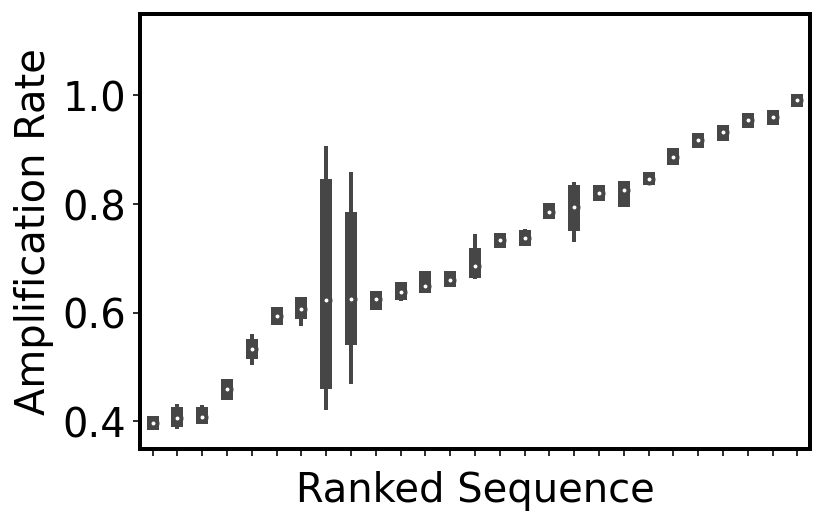

In [7]:
fltr = 'Parameter == "r" & Gene=="TMCC1"'
df = rxn_ests.query(fltr).sort_values('mean')
order = param_stats.query(fltr).sort_values('50%').Tar

sns.violinplot(x='Tar', y='mean', data = df, order=order)
ax = plt.gca()
for a in ax.collections:
    a.remove()
#sns.stripplot(x='Tar', y='mean', data = df, order=order, alpha=0.5)
ax.set_xticklabels('');
ax.set_xlabel('Ranked Sequence');
ax.set_ylabel('Amplification Rate');
ax.set_xlim([-0.5, len(df.Tar.unique())-0.5])
ax.set_ylim([0.35, 1.15])

savemyfig(plt.gcf(),'Ranked Rates')

In [8]:
unreliable = (rxn_ests
              .query(fltr)
              .groupby(['Gene','Tar'])['mean']
              .describe()
              .apply(lambda row: row['75%']-row['25%'], axis=1)
              .sort_values()[-2:]
              .index.to_list()
             )
def remove_unreliable(df):
    remove = (sum(
        df.apply(lambda row: (row.Gene,row.Tar), axis=1) == pair
        for pair in unreliable).astype(bool))
    return df.drop(df[remove].index)
    
rxn_ests=remove_unreliable(rxn_ests)
param_stats=remove_unreliable(param_stats)

In [9]:
classical_design = 'BP>30 & BP<110 & GC>0.4 & GC<0.6'
classical_targets = param_stats.query(fltr + ' & ' + classical_design).sort_values('50%')
x = np.arange(len(order))
idx = [i for i,tar in enumerate(order.values) if tar in classical_targets.Tar.values]
idx

[14, 18, 20, 21, 23]

## Determine mean and stdev of "r" in order to standardize it

In [10]:
with open(rslt_pth / 'JG047 Standardizers.pkl','rb') as buff:
    stdzr = pickle.load(buff)['stdzr']
    
stdzr['r'] = dict()
    
stdzr['r'] = {'μ': rxn_ests.query('Parameter=="r"')['mean'].mean(),
              'σ': rxn_ests.query('Parameter=="r"')['mean'].std()}

stdz, unstdz, _, _, get_BP, get_GC = pQS.build_standardizers(stdzr)
with open(rslt_pth / 'JG047 Standardizers.pkl','wb') as buff:
    pickle.dump({'stdzr':stdzr},buff)

Saving..Done


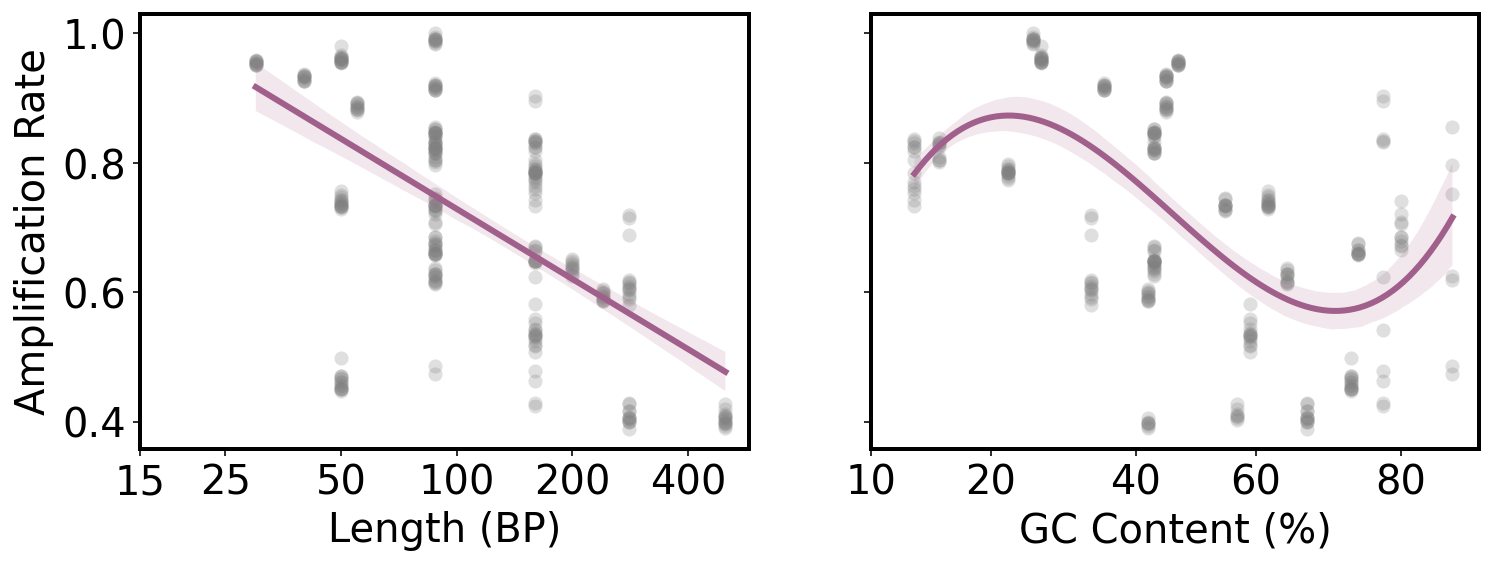

In [11]:
BPticks = [15,25,50,100,200,400]
GCticks = [10,20,40,60,80]

fig,axs = plt.subplots(1,2,figsize = (12,4),sharey=True)
sns.scatterplot(x='BP_z', y='mean', data = df, ax=axs[0], color=[0.5,0.5,0.5], s=50, alpha=0.25, linewidth=0,legend=False)
xl0 = axs[0].get_xlim()
sns.scatterplot(x='GC_z', y='mean', data = df, ax=axs[1], color=[0.5,0.5,0.5], s=50, alpha=0.25, linewidth=0,legend=False)
xl1 = axs[1].get_xlim()
sns.regplot(x='BP_z', y='mean', data = df, ax=axs[0], color=palette[3], order=1, scatter = False)
axs[0].set_xlim(xl0)
sns.regplot(x='GC_z', y='mean', data = df, ax=axs[1], color=palette[3], order=3, scatter = False)
axs[1].set_xlim(xl1)
axs[0].set_ylabel('Amplification Rate')
axs[1].set_ylabel('');

axs[0].set_xticks(stdz(BPticks,'BP'))
axs[0].set_xticklabels(BPticks)
axs[0].set_xlabel('Length (BP)')
axs[1].set_xticks(stdz(np.array(GCticks)/100,'GC'))
axs[1].set_xticklabels(GCticks)
axs[1].set_xlabel('GC Content (%)');

savemyfig(plt.gcf(),'Marginal Rate Trends')

# Fit a GP on TMCC1

In [12]:
gp_indiv = dict()
mp_indiv = dict()
model_indiv = dict()
for gene in genes:
    r_df = rxn_ests.query('Parameter=="r" & Gene==@gene')
    X = np.vstack([
        r_df.BP_z,
        r_df.GC_z
    ]).T

    y = stdz(r_df['mean'],'r').values

    BP_distances = pdist(X[:,0][:,None])
    GC_distances = pdist(X[:,1][:,None])

    ℓ_l_BP = BP_distances[BP_distances!=0].min()
    ℓ_u_BP = BP_distances[BP_distances!=0].max()
    ℓ_σ_BP = (ℓ_u_BP-ℓ_l_BP)/6
    ℓ_μ_BP = ℓ_l_BP + 3*ℓ_σ_BP

    ℓ_l_GC = GC_distances[GC_distances!=0].min()
    ℓ_u_GC = GC_distances[GC_distances!=0].max()
    ℓ_σ_GC = max(0.1,(ℓ_u_GC-ℓ_l_GC)/6)
    ℓ_μ_GC = ℓ_l_GC + 3*ℓ_σ_GC

    ℓ_μ = np.array([ℓ_μ_BP,ℓ_μ_GC])
    ℓ_σ = np.array([ℓ_σ_BP,ℓ_σ_GC])

    D_in = 2

    with pm.Model() as model_indiv[gene]:
        ℓ = pm.InverseGamma('ℓ', mu=ℓ_μ, sigma=ℓ_σ, shape=D_in)
        η = pm.Gamma('η', alpha=2, beta=1)
        cov_EQ = η**2 * pm.gp.cov.ExpQuad(input_dim=D_in, ls=ℓ)
        
        α_BP = pm.Normal('α_BP', mu=0, sigma=1)
        β_BP = pm.HalfNormal('β_BP', sigma=1)
        cov_Lin = β_BP**2 * pm.gp.cov.Linear(input_dim=D_in, c=α_BP, active_dims=[0])
        
        cov = cov_EQ + cov_Lin
        gp = gp_indiv[gene] = pm.gp.Marginal(cov_func=cov)

        σ = pm.Exponential('σ', lam=1)
        vals = gp.marginal_likelihood('r', X=X, y=y, noise=σ)

        mp_indiv[gene] = pm.find_MAP()
        #trace_joint = pm.sample()

In [13]:
r_df = rxn_ests.query('Parameter=="r"')
X = np.vstack([
    r_df.BP_z,
    r_df.GC_z
]).T

res = 100
BP_new = np.hstack([
    np.linspace(stdz(10,'BP'), stdz(800,'BP'), res)[:,None],
    np.zeros([res,1])
])
GC_new = np.hstack([
    np.zeros([res,1]),
    np.linspace(stdz(0.075,'GC'), stdz(0.925,'GC'), res)[:,None]
])

new_grids =  BP_grid,GC_grid = np.meshgrid(BP_new[:,0],GC_new[:,1])
new_points = np.vstack([BP_grid.ravel(),GC_grid.ravel()]).T

<ipython-input-14-9bded3392e09>:23: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.scatter(these['GC_z'], these['BP_z'], c=these['mean'], cmap=cmap,


Saving..Done


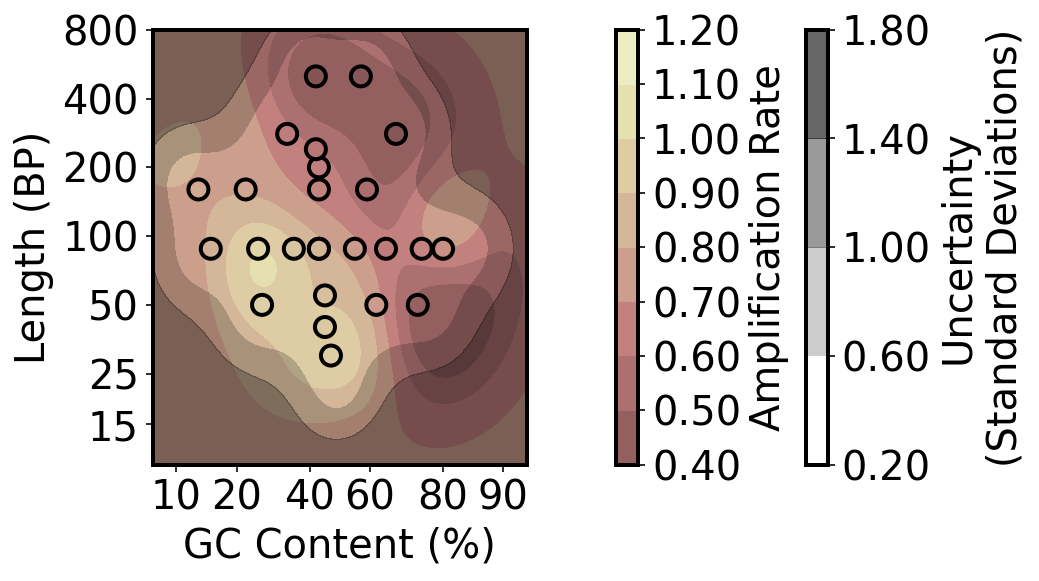

In [14]:
cmap = 'pink' #sns.cubehelix_palette(start=.5, rot=-.75, light=0.95, reverse=True, as_cmap=True)

pred_mean, pred_var = gp_indiv['TMCC1'].predict(new_points, point=mp_indiv['TMCC1'], diag=True, pred_noise=True)
pred_mean = pred_mean.T.reshape(res,res)
pred_mean = unstdz(pred_mean,'r')
pred_err = np.sqrt(pred_var.T.reshape(res,res))
#pred_err *= stdzr['r']['σ']

av_kws = dict()
av_kws['zlim'] = [0.4,1.2]
av_kws['label'] = 'Amplification Rate'
av_kws['zorder'] = -1
er_kws = dict()
er_kws['vmin'],er_kws['vmax'] = [0.2,1.8]
er_kws['label'] = 'Uncertainty\n(Standard Deviations)'
er_kws['zorder'] = +1
av_kws,er_kws = pmu.plot_VSUP(GC_grid, BP_grid, Z_av=pred_mean, Z_err=pred_err, cmap=cmap,
                              av_kws=av_kws, er_kws=er_kws)
ax = plt.gca()

these = param_stats.query('Gene=="TMCC1" & Parameter=="r"')

ax.scatter(these['GC_z'], these['BP_z'], c=these['mean'], cmap=cmap,
           norm=av_kws['norm'], vmin=av_kws['vmin'], vmax=av_kws['vmax'],
           ec='k', s=10**2, zorder=0);

yticks = [15,25,50,100,200,400,800]
xticks = [10,20,40,60,80,90]
#ticks = np.arange(-2,2.1,1)
ax.set_yticks(stdz(yticks,'BP'))
ax.set_xticks(stdz(np.array(xticks)/100,'GC'))
ax.set_yticklabels(yticks)
ax.set_xticklabels(xticks)
ax.set_ylabel('Length (BP)')
ax.set_xlabel('GC Content (%)');
ax.set_aspect('equal')

savemyfig(plt.gcf(),'TMCC1 VSUP')

Saving..Done


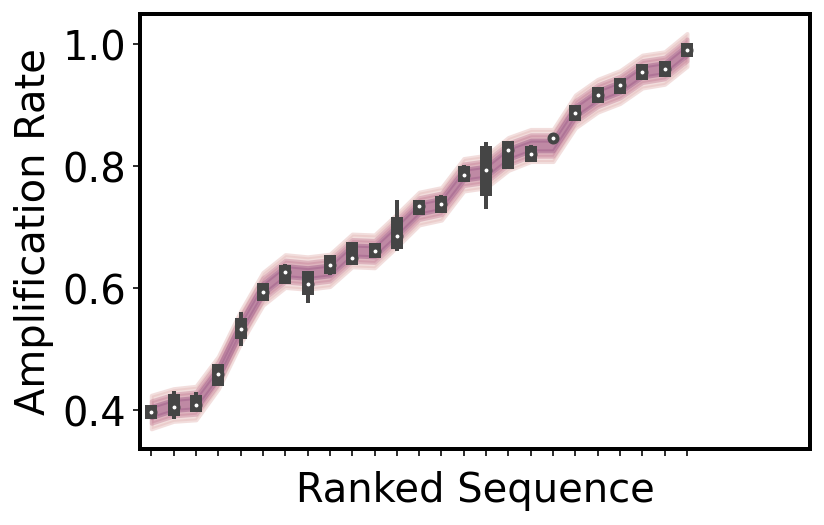

In [15]:
fltr = 'Parameter == "r" & Gene=="TMCC1"'
df = rxn_ests.query(fltr).sort_values('mean')
order = param_stats.query(fltr).sort_values('mean').Tar

ranked_pts = param_stats.query(fltr).sort_values('mean')[['BP_z','GC_z']].values
pred_mean, pred_var = gp_indiv['TMCC1'].predict(ranked_pts, point=mp_indiv['TMCC1'], diag=True, pred_noise=True)
pred_mean = unstdz(pred_mean,'r')
pred_err = np.sqrt(pred_var)*stdzr['r']['σ']

sns.violinplot(x='Tar', y='mean', data = df, order=order, zorder=10)
ax = plt.gca()
for a in ax.collections:
    a.remove()

for h,hpd in enumerate([3,2,1]):
    l = pred_mean-pred_err*hpd/2
    u = pred_mean+pred_err*hpd/2
    color = palette[h+1]
    plt.fill_between(np.arange(len(ranked_pts)), l, u, color=color, alpha=0.5, zorder=0)
#plt.plot(pred_mean, color=palette[-1], zorder=1)


#sns.stripplot(x='Tar', y='mean', data = df, hue='Tar_Q', order=order, alpha=0.5,
#              palette=sns.cubehelix_palette(start=.5, rot=-.75, light=0.95, n_colors=7))
#ax.get_legend().remove()
ax.set_xticklabels('');
ax.set_xlabel('Ranked Sequence');
ax.set_ylabel('Amplification Rate');
ax.set_xlim([-0.5, 29.5])

savemyfig(plt.gcf(),'Ranked Rates with GP')

<ipython-input-16-c482cc28b066>:19: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.scatter(these['GC_z'], these['BP_z'], c=these['mean'], cmap=cmap,


Saving..Done


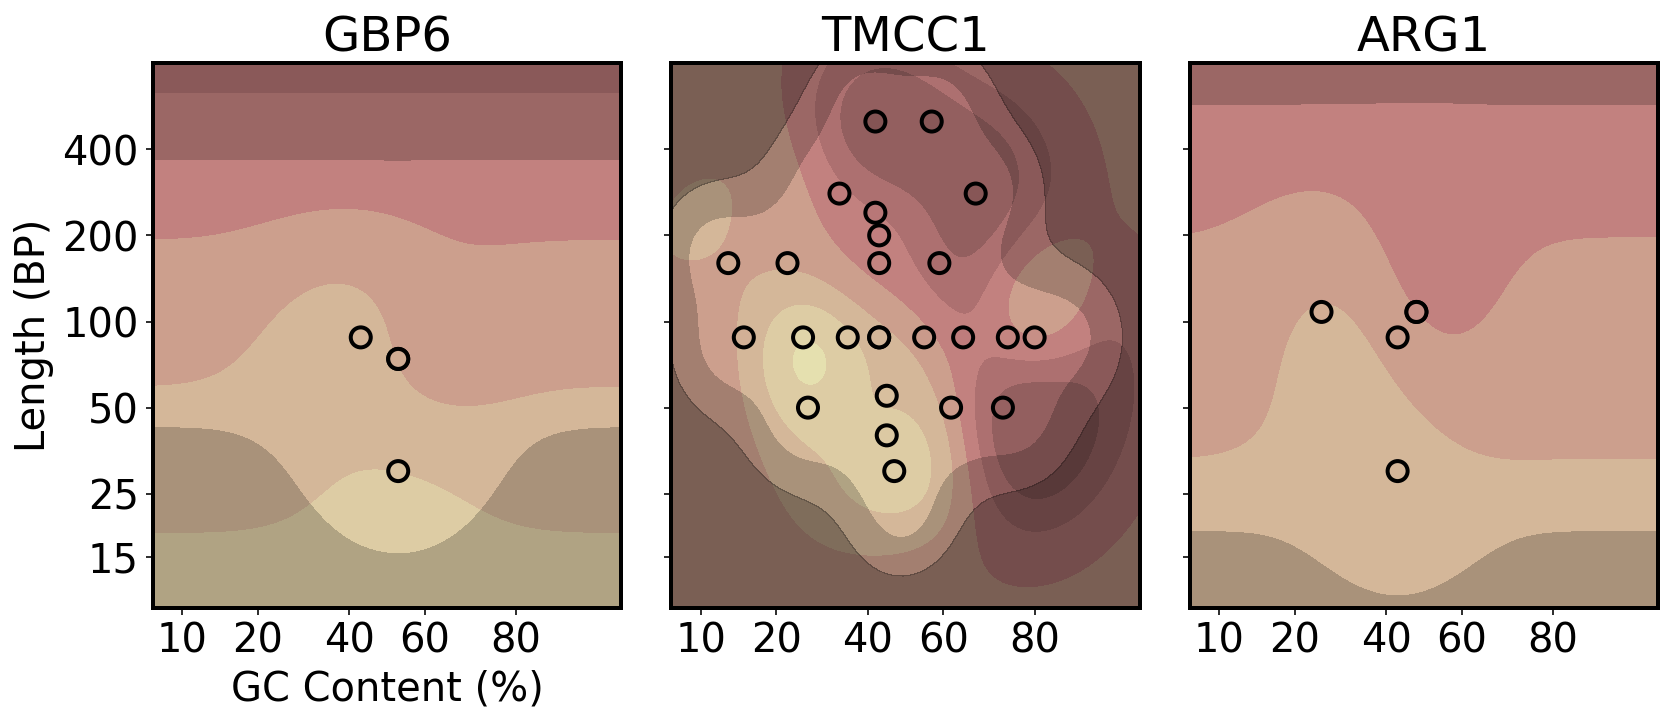

In [16]:
surfs_indiv = dict()

fig, axs = plt.subplots(1,3,figsize=(12,5), sharex=True, sharey=True)

for j,(gene,coord) in enumerate(gene_coords.items()):
    ax = axs[j]
    
    pred_mean, pred_var = gp_indiv[gene].predict(new_points, point=mp_indiv[gene], diag=True, pred_noise=True)
    pred_mean = pred_mean.T.reshape(res,res)
    pred_mean = surfs_indiv[gene] = unstdz(pred_mean,'r')
    pred_err = np.sqrt(pred_var.T.reshape(res,res))
    #pred_err *= stdzr['r']['σ']
    
    pmu.plot_VSUP(GC_grid, BP_grid, Z_av=pred_mean, Z_err=pred_err, cmap=cmap, ax=ax,
              av_kws = av_kws, er_kws=er_kws, av_cbar=False, er_cbar=False)
            
    these = param_stats.query('Gene==@gene & Parameter=="r"')
    
    ax.scatter(these['GC_z'], these['BP_z'], c=these['mean'], cmap=cmap,
               norm=av_kws['norm'], vmin=av_kws['vmin'], vmax=av_kws['vmax'],
               ec='k', s=10**2, zorder=0);

    ax.set_aspect('equal')
    ax.set_title(gene)
    ax.set_yticks(stdz(BPticks,'BP'))
    ax.set_xticks(stdz(np.array(GCticks)/100,'GC'))
    ax.set_yticklabels(BPticks)
    ax.set_xticklabels(GCticks)

axs[0].set_ylabel('Length (BP)')
axs[0].set_xlabel('GC Content (%)');
    
plt.tight_layout();
savemyfig(plt.gcf(),'All genes - independent VSUP')

# Fit a joint GP

In [17]:
r_df = rxn_ests.query('Parameter=="r"')
X = np.vstack([
    r_df.BP_z,
    r_df.GC_z,
    r_df['Gene'].replace(gene_coords),
]).T

y = stdz(r_df['mean'],'r').values

BP_distances = pdist(X[:,0][:,None])
GC_distances = pdist(X[:,1][:,None])

ℓ_l_BP = BP_distances[BP_distances!=0].min()
ℓ_u_BP = BP_distances[BP_distances!=0].max()
ℓ_σ_BP = (ℓ_u_BP-ℓ_l_BP)/6
ℓ_μ_BP = ℓ_l_BP + 3*ℓ_σ_BP

ℓ_l_GC = GC_distances[GC_distances!=0].min()
ℓ_u_GC = GC_distances[GC_distances!=0].max()
ℓ_σ_GC = (ℓ_u_GC-ℓ_l_GC)/6
ℓ_μ_GC = ℓ_l_GC + 3*ℓ_σ_GC

ℓ_l_cat = 0.1
ℓ_u_cat = 3
ℓ_σ_cat = (ℓ_u_cat-ℓ_l_cat)/6
ℓ_μ_cat = ℓ_l_cat + 3*ℓ_σ_cat

ℓ_μ = np.array([ℓ_μ_BP,ℓ_μ_GC,ℓ_μ_cat])
ℓ_σ = np.array([ℓ_σ_BP,ℓ_σ_GC,ℓ_σ_cat])

D_in = 3

with pm.Model() as model_joint:
    ℓ = pm.InverseGamma('ℓ', mu=ℓ_μ, sigma=ℓ_σ, shape=D_in)
    η = pm.Gamma('η', alpha=2, beta=1)
    cov_EQ = η**2 * pm.gp.cov.ExpQuad(input_dim=D_in, ls=ℓ)

    α_BP = pm.Normal('α_BP', mu=0, sigma=1)
    β_BP = pm.HalfNormal('β_BP', sigma=1)
    cov_Lin = β_BP**2 * pm.gp.cov.Linear(input_dim=D_in, c=α_BP, active_dims=[0])

    cov = cov_EQ + cov_Lin
    gp = gp_joint = pm.gp.Marginal(cov_func=cov)

    σ = pm.Exponential('σ', lam=1)
    vals = gp.marginal_likelihood('r', X=X, y=y, noise=σ)

    joint_mp = pm.find_MAP()
    #trace_joint = pm.sample()

<ipython-input-18-e79b1ddd8a15>:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.scatter(those['GC_z'], those['BP_z'], c=those['mean'], cmap=cmap,
<ipython-input-18-e79b1ddd8a15>:26: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.scatter(these['GC_z'], these['BP_z'], c=these['mean'], cmap=cmap,


Saving..Done


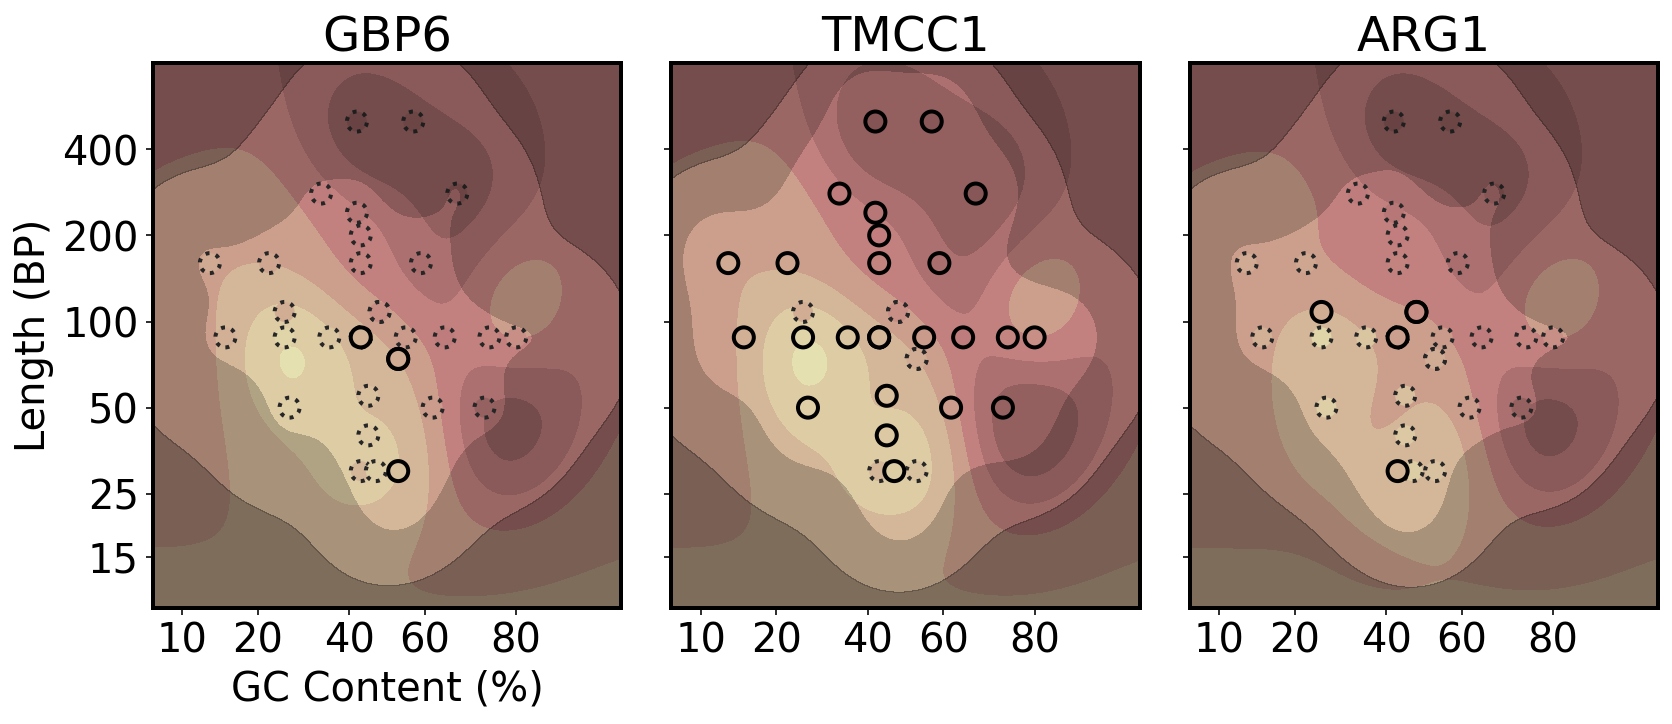

In [18]:
surfs_joint = dict()

fig, axs = plt.subplots(1,3,figsize=(12,5), sharex=True, sharey=True)

for j,(gene,coord) in enumerate(gene_coords.items()):
    ax = axs[j]
    
    these_points = np.hstack([new_points,np.full([len(new_points),1],coord)])
    
    pred_mean, pred_var = gp_joint.predict(these_points, point=joint_mp, diag=True, pred_noise=True)
    pred_mean = pred_mean.T.reshape(res,res)
    pred_mean = surfs_joint[gene] = unstdz(pred_mean,'r')
    pred_err = np.sqrt(pred_var.T.reshape(res,res))
    #pred_err *= stdzr['r']['σ']
    
    pmu.plot_VSUP(GC_grid, BP_grid, Z_av=pred_mean, Z_err=pred_err, cmap=cmap, ax=ax,
              av_kws = av_kws, er_kws=er_kws, av_cbar=False, er_cbar=False)
            
    those = param_stats.query('Gene!=@gene & Parameter=="r"')
    these = param_stats.query('Gene==@gene & Parameter=="r"')
    
    ax.scatter(those['GC_z'], those['BP_z'], c=those['mean'], cmap=cmap,
               norm=av_kws['norm'], vmin=av_kws['vmin'], vmax=av_kws['vmax'],
               ls = ':', ec=[0.15,0.15,0.15], s=10**2, zorder=0);
    
    ax.scatter(these['GC_z'], these['BP_z'], c=these['mean'], cmap=cmap,
               norm=av_kws['norm'], vmin=av_kws['vmin'], vmax=av_kws['vmax'],
               ec='k', s=10**2, zorder=0);

    ax.set_aspect('equal')
    ax.set_title(gene)
    ax.set_yticks(stdz(BPticks,'BP'))
    ax.set_xticks(stdz(np.array(GCticks)/100,'GC'))
    ax.set_yticklabels(BPticks)
    ax.set_xticklabels(GCticks)

axs[0].set_ylabel('Length (BP)')
axs[0].set_xlabel('GC Content (%)');
    
plt.tight_layout();
savemyfig(plt.gcf(),'All genes - joint VSUP')

Saving..Done


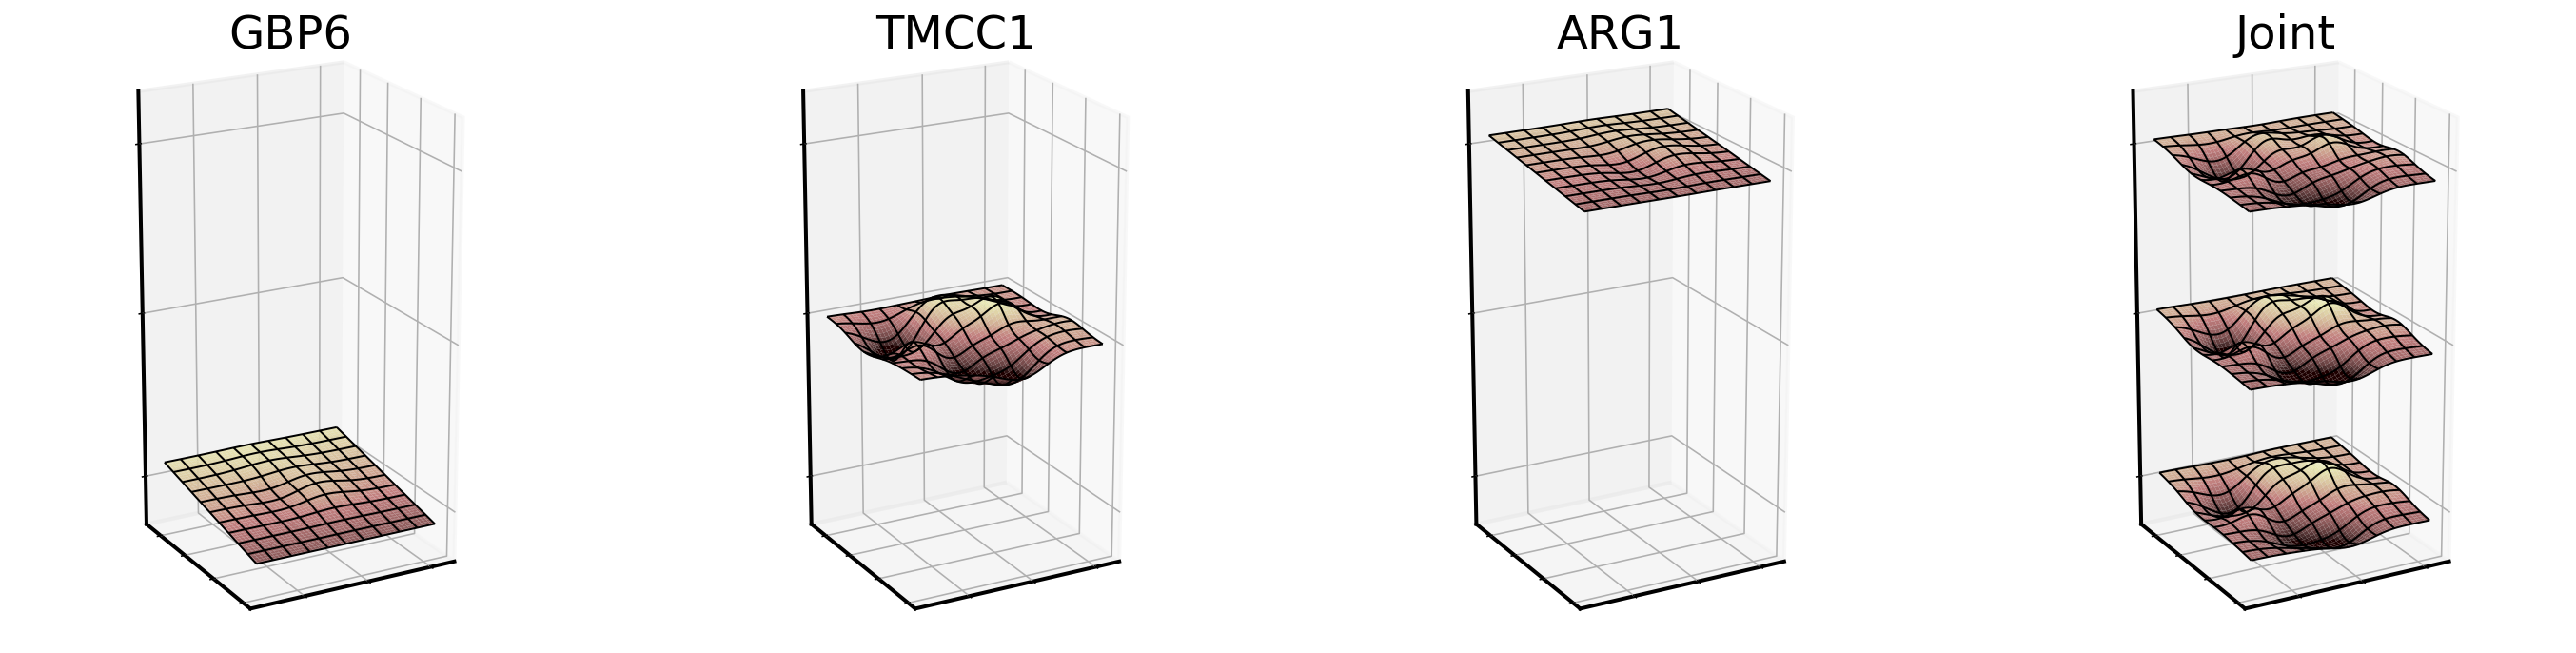

In [19]:
fig = plt.figure(figsize=(12*2,10*2))
zlim = [-0.5,4.5]
elev = 20
azim = 61.5
pt_offset=0.15

def format_pts(x,y,c,offset):
    idx = np.argsort(x.flatten()*y.flatten())#[::-1]
    x=x.flatten()[idx]
    y=y.flatten()[idx]
    z=np.zeros_like(x)+offset-pt_offset
    c=c.flatten()[idx]
    return x,y,z,c

def plot_vert_lines(x,y,z,offset,ax):
    for i in range(len(x.flatten())):
        x_ = x.flatten()[i]
        y_ = y.flatten()[i]
        z_ = [z[i]+offset,offset-pt_offset]
        ax.plot([x_,x_],[y_,y_],z_,color='k')

axs=[]
for g in range(len(genes)+1):
    ax = fig.add_subplot(1,len(genes)+1,g+1, projection='3d')
    ax.view_init(elev,azim)
    ax.set_yticks(stdz(yticks[::2],'BP'))
    ax.set_xticks(stdz(np.array(xticks[::2])/100,'GC'))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    #ax.set_ylabel('BP')
    #ax.set_xlabel('GC')
    ax.set_zticklabels([])
    ax.set_zticks([0,2,4])
    ax.set_zlim(zlim);
    axs.append(ax)

ax_j = axs[-1]
ax_j.set_title('Joint')
    
for g,gene in enumerate(genes):
    
    ax_i = axs[g]
    ax_i.set_title(gene)

    offset = -0.75+g*2
    vmin=av_kws['vmin']+offset+0.25
    vmax=av_kws['vmax']+offset-0.25

    ax_i.plot_surface(GC_grid, BP_grid, surfs_indiv[gene]+offset, cmap=cmap,
                      vmin=vmin, vmax=vmax)
    ax_i.plot_wireframe(GC_grid, BP_grid, surfs_indiv[gene]+offset, color='k', rcount=10, ccount=10, lw=1)
    
    
    ax_j.plot_surface(GC_grid, BP_grid, surfs_joint[gene]+offset, cmap=cmap,
                       vmin=vmin, vmax=vmax)
    ax_j.plot_wireframe(GC_grid, BP_grid, surfs_joint[gene]+offset, color='k', rcount=10, ccount=10, lw=1)
    
    #these = param_stats.query('Parameter=="r" & Gene==@gene')
    #x=these['GC_z'].values
    #y=these['BP_z'].values
    #z=these['mean'].values
    #x_,y_,z_,c_ = format_pts(x,y,z,offset)
    #ax_i.scatter(x_, y_, z_, c=c_, ec='k', s=10**2, cmap=cmap, vmin=vmin-offset, vmax=vmax-offset, depthshade=False)
    #plot_vert_lines(x_, y_, z, offset, ax_i)
    #ax_j.scatter(x_, y_, z_, c=c_, ec='k', s=10**2, cmap=cmap, vmin=vmin-offset, vmax=vmax-offset, depthshade=False)
    #plot_vert_lines(x_, y_, z, offset, ax_j)
    
for ax in axs:
    ax.set_box_aspect((1,1,2))
savemyfig(plt.gcf(),'All genes - surfaces')